## "Определение музыкального жанра по изображению обложки альбома"
### Описание проекта
Существует явная связь между оформлением музыкального альбома и его содержанием. Но насколько они связаны? Как можно подтвердить эту связь? На основе данных и какова практическая польза этого?

## Основная задача
Разработать модель, которая будет определять жанр музыкального альбома по изображению его обложки.

## Дополнительные задачи
- **Кластеризация:** Исследовать, какие жанры легко различимы, а какие трудно отделить друг от друга.
- **Интеграция API:** Использовать API MusicBrainz для расширения датасета новыми изображениями. Можно добавить дополнительные жанры и использовать изображения с обратной стороны обложек.
- **OCR + NLP:** Извлечь текст с изображения и улучшить решение с помощью технологий обработки естественного языка.
- **Система рекомендаций:** Создать мини-систему рекомендаций на основе обложек альбомов.
- **Веб-приложение:** Разработать веб-приложение для классификации жанров или системы рекомендаций с использованием Streamlit.

## Данные
Изображения представлены в формате PNG, упакованные в ZIP-архивы. Название каждого архива соответствует музыкальному жанру, и каждый архив содержит папку с изображениями обложек альбомов этого жанра.

## Метрики
Метрики для оценки классификации включают в себя Точность (Accuracy), Прецизионность (Precision), Полноту (Recall) и F1-меру. Можно предложить дополнительные метрики в рамках исследования.


## План проекта:

- Определение целей проекта
- Сбор, подготовка и исследование данных
- Предварительная обработка данных
- Разработка модели машинного обучения
- Обучение модели
- Разработка глубокой учебной модели
- Обучение глубокой учебной модели
- Визуализация результатов
- Оценка моделей
- Выводы

## Рекомендация по дальнейшему развитию проекта:
- Оптимизация и тонкая настройка
1) Провести тонкую настройку гиперпараметров моделей.
2) Экспериментировать с различными техниками улучшения моделей, включая аугментацию данных.

- Интеграция и деплой
1) Разработать API или веб-интерфейс для использования модели.
2) Опубликовать модель и интерфейс для использования конечными пользователями.

- Мониторинг и обслуживание
1) Настроить систему мониторинга для отслеживания производительности модели в продакшене.
2) Планировать регулярное обновление модели с учетом новых данных и обратной связи пользователей.

- Документация и отчетность
1) Подготовить техническую документацию по проекту.
2) Создать отчеты о результатах исследования и разработки проекта.


### Загрузка библиотек

In [36]:
# Импорт необходимых библиотек
import os
import glob
import zipfile
import urllib.request
import requests
from pathlib import Path

# Библиотеки для работы с данными и машинного обучения
import pandas as pd
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# PyTorch и torchvision для глубокого обучения и трансформаций
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms

# FastAI для упрощения подходов к глубокому обучению
from fastai.vision.all import *
from fastai.callback.tracker import EarlyStoppingCallback
from fastai.metrics import Precision, Recall

# FAISS для эффективного поиска по схожести и кластеризации плотных векторов
import faiss

# Отключение предупреждений
import warnings
warnings.filterwarnings("ignore")

# Установка пути к основной папке с данными
root_path = Path('/Users/kseniiabogatenkova/ProgectOCRNLP')

# Установка переменных окружения для SSL, если необходимо (убраны, так как в некоторых случаях они могут не потребоваться)
# os.environ['SSL_CERT_FILE'] = '/path/to/certificate.crt'
# os.environ['SSL_CERT_DIR'] = '/path/to/certificates/directory'


### 2. Сбор, подготовка и исследование данных
- Собрать или подготовить датасет изображений, разделенных по жанровым папкам.
- Написать скрипты для загрузки и организации данных по соответствующим папкам.
- Проверить наличие и корректность изображений в каждой папке.
- Провести первичный анализ данных для оценки качества и разнообразия изображений.
- Визуализировать некоторые изображения для проверки их корректности.


In [2]:
# Получение текущего рабочего каталога
current_working_directory = os.getcwd()
print(f"Текущий рабочий каталог: {current_working_directory}")

Текущий рабочий каталог: /Users/kseniiabogatenkova/ProgectOCRNLP


Для сбора данных из различных жанров (папок) и создания универсального кода, не требующего изменений при изменении количества классов, использую комбинацию os.walk и os.path.basename. 

In [3]:
def gather_image_paths(base_dir: str, pattern: str = '*.png'):
    """
    Сбор путей к изображениям из всех поддиректорий в базовой папке.
    :param base_dir: Путь к базовой папке, содержащей папки-классы (жанры).
    :param pattern: Шаблон поиска файлов, например '*.png'.
    :return: Словарь {имя_папки: список_путей_к_изображениям}.
    """
    image_paths = {}
    
    # Проход по всем поддиректориям внутри base_dir
    for root, dirs, files in os.walk(base_dir):
        for directory in dirs:
            dir_path = os.path.join(root, directory)
            images = glob.glob(os.path.join(dir_path, pattern))
            if images:
                image_paths[os.path.basename(directory)] = images
    
    return image_paths

def show_image_grid(image_paths_dict, num_images_per_class: int = 2, grid_shape: tuple = (4, 5)):
    """
    Показывает сетку изображений из нескольких классов.

    :param image_paths_dict: Словарь {имя_класса: список_путей_к_изображениям}.
    :param num_images_per_class: Количество изображений для отображения из каждого класса.
    :param grid_shape: Размеры сетки (количество строк, количество столбцов).
    """
    all_images = []

    # Собираем нужное количество изображений из каждого класса
    for class_name, image_paths in image_paths_dict.items():
        all_images.extend(image_paths[:num_images_per_class])

    # Проверяем, нашли ли мы изображения
    if not all_images:
        print("Изображения не найдены. Проверьте путь к файлам.")
        return

    # Создаем сетку для отображения всех изображений
    fig, axes = plt.subplots(*grid_shape, figsize=(15, 10))
    axes = axes.ravel()

    # Открываем и показываем изображения
    for i, image_path in enumerate(all_images[:len(axes)]):
        image = Image.open(image_path)
        axes[i].imshow(image)
        axes[i].axis('off')

    # Отключаем лишние оси
    for j in range(len(all_images[:len(axes)]), len(axes)):
        axes[j].axis('off')

    plt.show()


***Принципы работы кода:***   

- gather_image_paths:  функция ищет пути к изображениям во всех поддиректориях базовой папки.  
Использует os.walk для рекурсивного поиска и извлекает имена поддиректорий как названия классов (жанров).  
Создает словарь с ключами как имена классов и значениями как списки путей к изображениям.    
- show_image_grid: принимает словарь путей к изображениям и отображает нужное количество изображений из каждого класса в виде сетки.

 
***Универсальность:***
   
Этот подход работает с различными жанрами без изменения кода, потому что он рекурсивно обходит все поддиректории в базовой папке и обрабатывает их динамически.

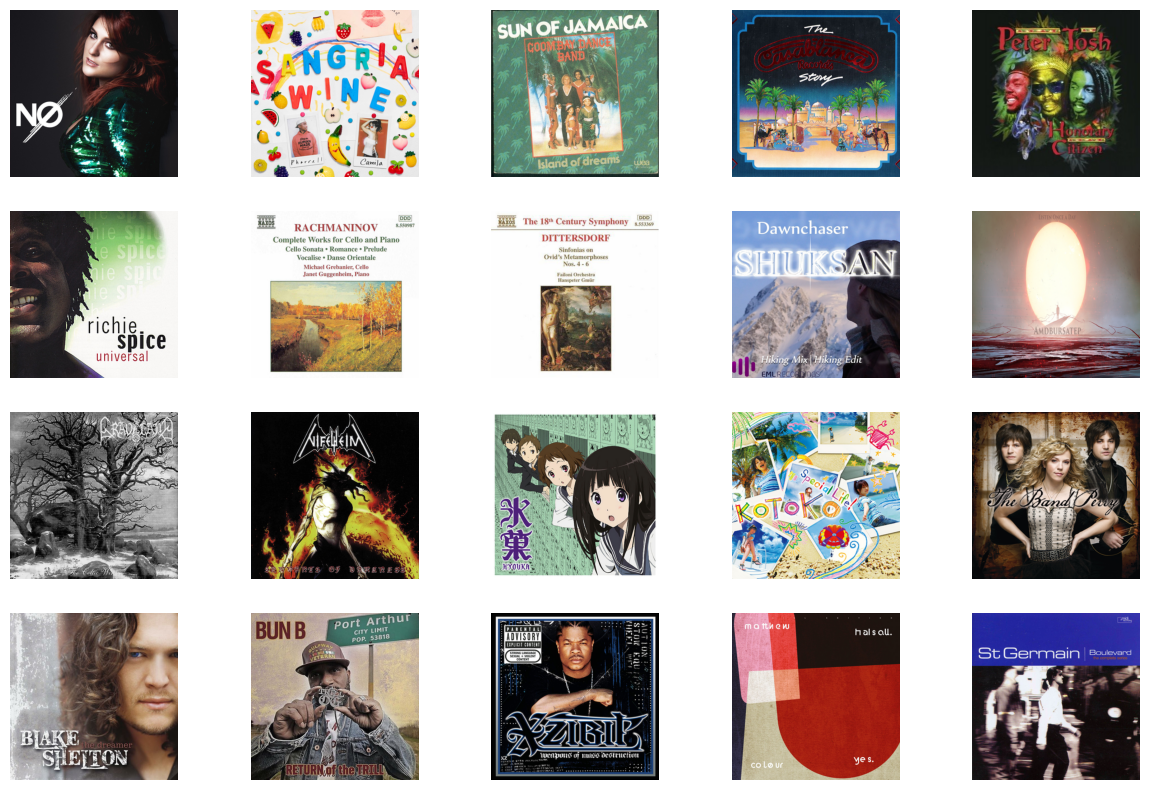

In [4]:
# Путь к базовому каталогу с изображениями
base_dir = '/Users/kseniiabogatenkova/ProgectOCRNLP'

# Словарь с путями к изображениям из всех классов
image_paths_dict = gather_image_paths(base_dir, '*.png')

# Отобразить изображения (по 2 изображения из каждого класса в сетке 4x5)
show_image_grid(image_paths_dict, num_images_per_class=2, grid_shape=(4, 5))


In [5]:
# Убедимся, что CUDA доступен, если есть GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### Предварительная обработка данных
- Преобразовать изображения в единый формат и размер.
- Разделить данные на обучающую и тестовую выборки.

In [6]:
# Функция для поиска и вывода дубликатов на основе хешей
def find_image_duplicates(directory: str, pattern: str = '*.png'):
    hashes = {}
    duplicates = []

    for filename in glob.glob(os.path.join(directory, pattern)):
        with open(filename, 'rb') as img_file:
            img_hash = hashlib.md5(img_file.read()).hexdigest()

        if img_hash in hashes:
            duplicates.append((filename, hashes[img_hash]))
        else:
            hashes[img_hash] = filename

    # Вывод найденных дубликатов
    if duplicates:
        print("Найдены дубликаты:")
        for duplicate, original in duplicates:
            print(f"Дубликат: {duplicate}, Оригинал: {original}")
    else:
        print("Дубликаты не найдены.")
        
    return duplicates


In [7]:
# Определение трансформации для обработки изображений
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [8]:
# Загрузка предварительно обученной модели ResNet50
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
model = nn.Sequential(*(list(model.children())[:-1]))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()
# Добавляем эту строку для предотвращения вывода описания модели
print("Model is ready and configured.")

Using cache found in /Users/kseniiabogatenkova/.cache/torch/hub/pytorch_vision_v0.10.0


Model is ready and configured.


In [9]:
# Функция для извлечения эмбеддингов
def get_embedding(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model(image).cpu().numpy().flatten()
    return embedding

# Загрузка данных и меток
categories = ['anime', 'black metal', 'classical', 'country', 'disco', 'edm', 'jazz', 'pop', 'rap', 'reggae']
image_paths = []
labels = []

for category in categories:
    category_paths = glob.glob(f'{base_dir}/{category}/*.png')
    image_paths.extend(category_paths)
    labels.extend([category] * len(category_paths))

# Преобразование меток в числовой формат
le = LabelEncoder()
labels = le.fit_transform(labels)

# Получение эмбеддингов и создание DataFrame
embeddings = np.array([get_embedding(path) for path in image_paths])
df = pd.DataFrame({'path': image_paths, 'label': labels, 'embedding': list(embeddings)})

# Найти дубликаты по хешам и вывести их
duplicates = find_image_duplicates(base_dir)

# Удалить дубликаты из DataFrame
if duplicates:
    duplicate_files = [item[0] for item in duplicates]
    df = df[~df['path'].isin(duplicate_files)]


Дубликаты не найдены.


In [10]:
# Получаем эмбеддинги и метки после фильтрации
X = np.stack(df['embedding'].values)
y = df['label'].values

# Разделение данных на обучающую, валидационную и тестовую выборки
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [11]:
# Создание FAISS индекса
index = faiss.IndexFlatL2(X_train.shape[1])
index.add(X_train)

# Функция поиска ближайших соседей в тестовой выборке
def search_similar_images(query_embedding, k=5):
    distances, indices = index.search(np.array([query_embedding]), k)
    return indices[0]  # Возвращает все совпадения

# Пример поиска для одного изображения из тестовой выборки
query_idx = 0
similar_indices = search_similar_images(X_test[query_idx], k=5)

# Печать результатов
print(f"Тестовое изображение (label: {y_test[query_idx]}) похоже на следующие:")
for idx in similar_indices:
    print(f"- {df.iloc[idx]['path']} (label: {y_train[idx]})")


Тестовое изображение (label: 6) похоже на следующие:
- /Users/kseniiabogatenkova/ProgectOCRNLP/black metal/00c25888-f6ec-4dc0-bf2c-38c82b1f0609.png (label: 6)
- /Users/kseniiabogatenkova/ProgectOCRNLP/black metal/0fe8a168-bc86-49b1-b114-c2e383271ed0.png (label: 2)
- /Users/kseniiabogatenkova/ProgectOCRNLP/country/aae883ce-905d-4b1b-8440-037e4102bf7a.png (label: 6)
- /Users/kseniiabogatenkova/ProgectOCRNLP/country/b0126638-cfe0-47e0-9c2a-d110e9d61775.png (label: 6)
- /Users/kseniiabogatenkova/ProgectOCRNLP/anime/7b1e112a-ecc8-4ea5-89b3-a973de4b6e45.png (label: 2)


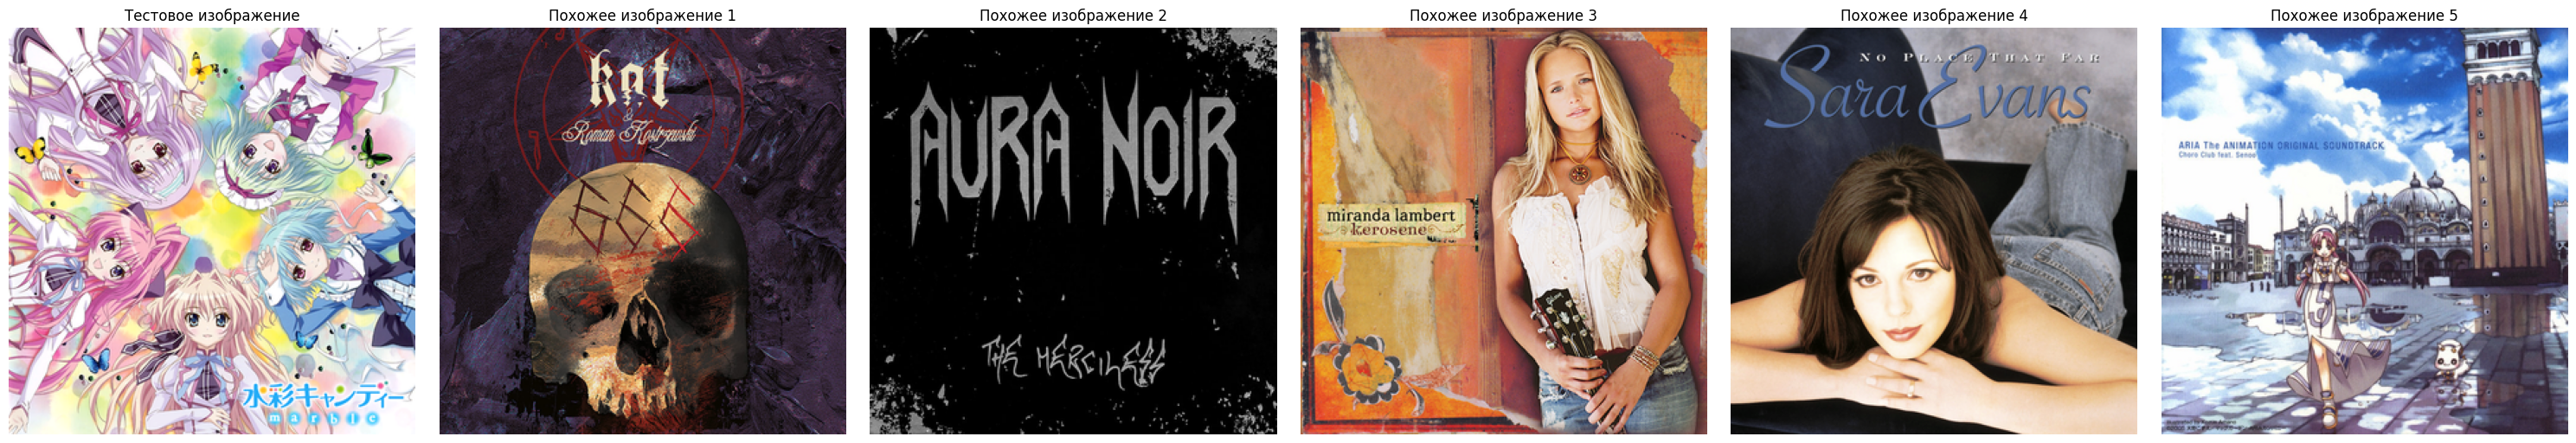

In [12]:
def visualize_similar_images(test_image_path, similar_image_paths):

    num_images = len(similar_image_paths) + 1
    fig, axes = plt.subplots(1, num_images, figsize=(5 * num_images, 5))
    
    # Отображаем тестовое изображение
    test_image = Image.open(test_image_path).convert('RGB')
    axes[0].imshow(test_image)
    axes[0].set_title("Тестовое изображение")
    axes[0].axis('off')
    
    # Отображаем похожие изображения
    for i, img_path in enumerate(similar_image_paths, start=1):
        img = Image.open(img_path).convert('RGB')
        axes[i].imshow(img)
        axes[i].set_title(f"Похожее изображение {i}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Пример использования функции
query_idx = 0
similar_indices = search_similar_images(X_test[query_idx], k=5)

# Извлекаем пути к тестовому и похожим изображениям
test_image_path = df.iloc[np.where(X == X_test[query_idx])[0][0]]['path']
similar_image_paths = [df.iloc[idx]['path'] for idx in similar_indices]

# Визуализируем тестовое изображение и похожие к нему
visualize_similar_images(test_image_path, similar_image_paths)


***Функция find_image_duplicates:***  
- ищет дубликаты по хешам и выводит список дубликатов в консоль.    
- возвращает список дублирующихся файлов для дальнейшей фильтрации.

***Удаление дубликатов:***    
- DataFrame фильтруется на основе списка дублирующихся файлов.

***FAISS:***  
- cтроится индекс FAISS на основе оставшихся уникальных изображений.  
- nестовое изображение используется для поиска похожих изображений.  


Этот подход гарантирует, что дублирующиеся изображения найдены и удалены, а также выводятся в виде списка в консоль для нашего контроля.

### Обучение модели
- Обучить выбранную модель на тренировочных данных.
- Провести кросс-валидацию для оценки стабильности модели.


In [13]:
# Создание модели CatBoost
catboost = CatBoostClassifier(verbose=0, iterations=1000)

# Обучение на обучающей выборке
catboost.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=20)

# Предсказание и оценка на тестовой выборке
y_pred = catboost.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Точность на тестовой выборке:", test_accuracy)
# Отчет о классификации на тестовой выборке с показом названий классов
class_names = le.inverse_transform(sorted(set(y)))  # Восстанавливаем названия классов
print("\nОтчет о классификации:\n", classification_report(y_test, y_pred, target_names=class_names, zero_division=0))


Точность на тестовой выборке: 0.6017094017094017

Отчет о классификации:
               precision    recall  f1-score   support

       anime       0.75      0.84      0.79       198
 black metal       0.79      0.86      0.82        70
   classical       0.74      0.66      0.70       140
     country       0.56      0.71      0.63       213
       disco       0.31      0.12      0.17        69
         edm       0.61      0.55      0.58       120
        jazz       0.42      0.38      0.40       125
         pop       0.44      0.52      0.47       112
         rap       0.61      0.26      0.37        42
      reggae       0.54      0.53      0.53        81

    accuracy                           0.60      1170
   macro avg       0.58      0.54      0.55      1170
weighted avg       0.59      0.60      0.59      1170



In [16]:
# Предсказание на тренировочной выборке
y_train_pred = catboost.predict(X_train)

# Расчет и вывод точности на тренировочной выборке
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Точность на тренировочной выборке:", train_accuracy)



Точность на тренировочной выборке: 0.9943223443223443


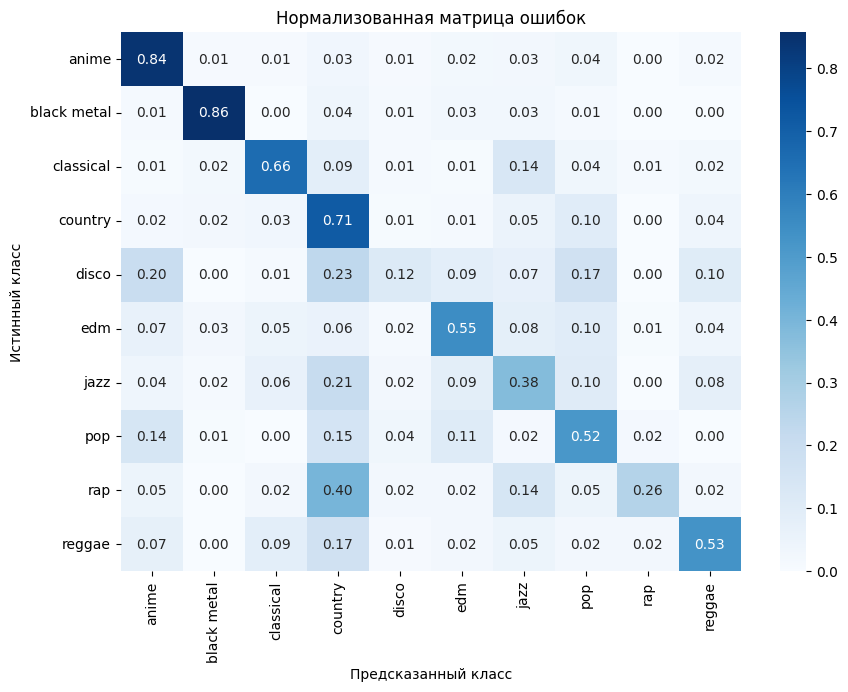

In [17]:
# Построение нормализованной матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_test_pred, normalize='true')
class_names = le.inverse_transform(sorted(set(y)))  # Восстанавливаем названия классов
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Предсказанный класс")
plt.ylabel("Истинный класс")
plt.title("Нормализованная матрица ошибок")
plt.show()



Нормализованная матрица ошибок показывает, что модель лучше всего справляется с классификацией жанров "anime", "black metal" и "edm". При этом категории "pop" и "rap" путаются с другими жанрами, что указывает на необходимость улучшения модели или данных в этих областях.

### Разработка глубокой учебной модели
- Загрузить и адаптировать предварительно обученную модель (например, ResNet-50).
- Настроить процесс трансферного обучения для адаптации модели к задаче.


In [25]:
# Проверка наличия основной папки
if not root_path.exists():
    print(f"Основная папка с данными не найдена: {root_path}")
else:
    print(f"Основная папка с данными найдена: {root_path}")

Основная папка с данными найдена: /Users/kseniiabogatenkova/ProgectOCRNLP


In [26]:
# Создание загрузчика данных, который автоматически берет метки из названий папок
dls = ImageDataLoaders.from_folder(root_path, valid_pct=0.2, seed=42, item_tfms=Resize(224))
print(f"Тренировочный набор: {len(dls.train_ds)}, Валидационный набор: {len(dls.valid_ds)}")

Тренировочный набор: 6240, Валидационный набор: 1560


In [ ]:
# Загрузка и инициализация модели ResNet50 с предобученными весами
learn = vision_learner(dls, resnet50, pretrained=True, metrics=accuracy)

# Обучение модели
learn.fine_tune(4)

# Анализ результатов обучения
learn.recorder.plot_loss()

# Создаем объект интерпретации для анализа классификации
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(5)

No improvement since epoch 3: early stopping


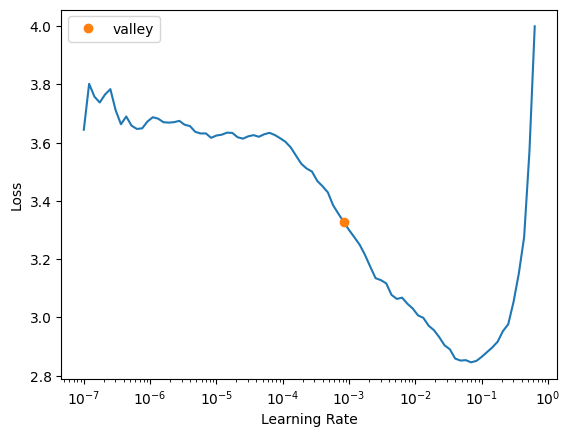

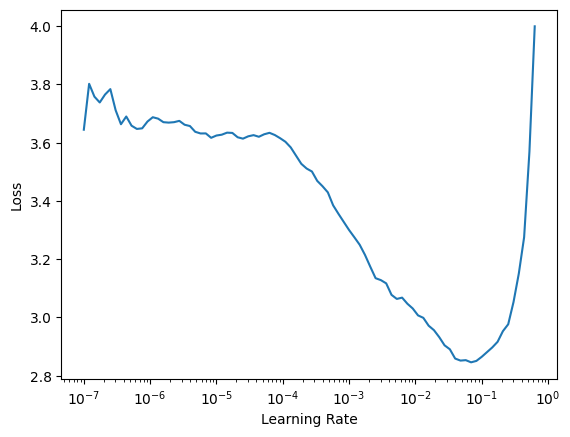

In [35]:
# Загрузка и инициализация модели ResNet50 с предобученными весами
learn = vision_learner(
    dls, resnet50, pretrained=True,
    metrics=[accuracy, Precision(average='weighted'), Recall(average='weighted')]
)

# Подбор оптимального learning rate с помощью lr_find
suggested_lr = learn.lr_find()  # Возвращает рекомендуемые значения learning rate
learn.recorder.plot_lr_find()  # Строит график кривой потерь

# Определяем оптимальный learning rate
optimal_lr = suggested_lr[0]

# Используем колбэк для ранней остановки
early_stop_cb = EarlyStoppingCallback(monitor='valid_loss', patience=3)

# Обучаем модель с ранней остановкой
learn.fine_tune(10, base_lr=optimal_lr, cbs=[early_stop_cb])


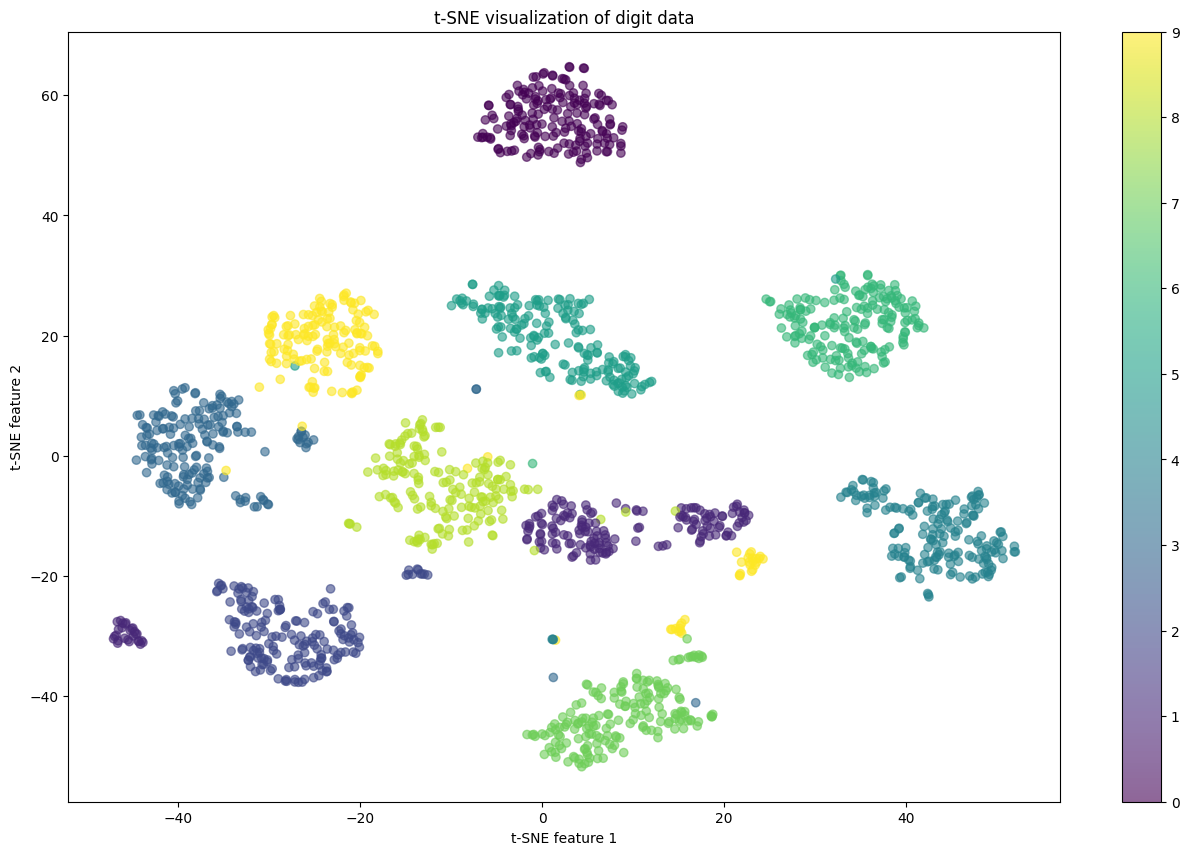

In [45]:
# Загрузка примера данных, набора данных рукописных цифр
data = load_digits()
X = data.data  # изображения цифр, уже в виде векторов признаков
y = data.target  # метки классов

# Применение t-SNE для уменьшения размерности данных до 2D
tsne = TSNE(n_components=2, random_state=0)
X_reduced = tsne.fit_transform(X)

# Визуализация результатов
plt.figure(figsize=(16, 10))
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.title('t-SNE visualization of digit data')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()

Первые 7 эпох модель показывает стабильное улучшение метрик за первые 7 эпох. Train_loss и valid_loss уменьшаются, а метрики accuracy, precision_score и recall_score постепенно повышаются. Это свидетельствует о том, что модель продолжает учиться.
Ранняя остановка: после третьей эпохи виден значительный прогресс, но начиная с четвертой эпохи улучшения уже менее заметны. Механизм ранней остановки активируется после седьмой эпохи, так как модель не улучшала valid_loss с третьей эпохи.
Итоговая точность: итоговое значение точности (accuracy) примерно составляет 0.673, что говорит об удовлетворительном результате.
Графики Learning Rate показывают точку "долины" (valley), указывающую на оптимальный диапазон learning rate, около 10^-3.
После этого значения график кривой потерь значительно снижается до минимума, а затем начинает стремительно расти. Это подтверждает, что оптимальный learning rate лежит в указанном диапазоне.
Рекомендации:

Можно использовать оптимальный learning rate из предложенного диапазона для дальнейшего fine-tuning.
Применение ранней остановки помогло определить оптимальное количество эпох и избежать излишнего переобучения.
Возможно, дальнейшее улучшение можно достичь путем оптимизации архитектуры или применения методов регуляризации.

In [44]:
# Используем базовый learning rate равный 0.001
#learn.fine_tune(10, base_lr=0.001)

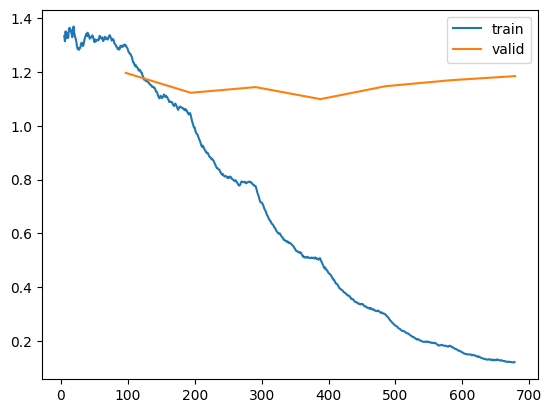

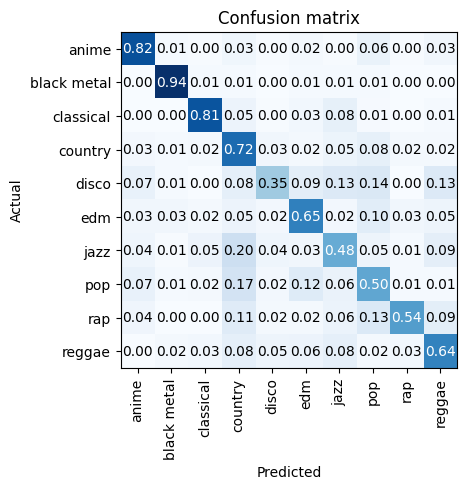

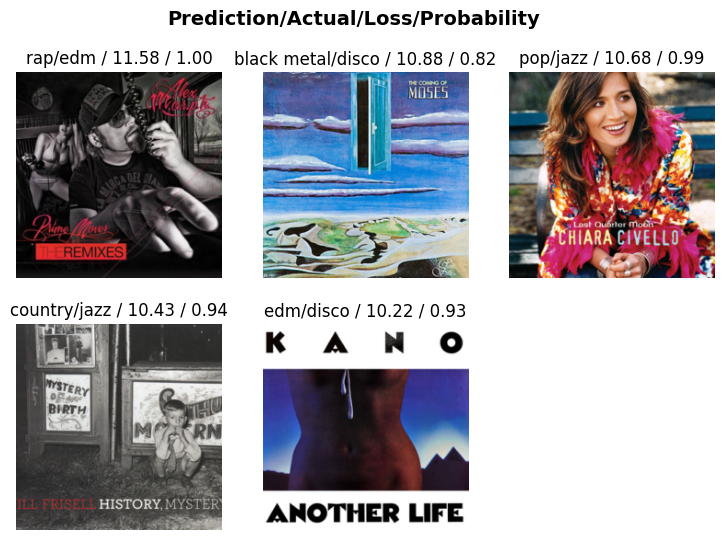

In [37]:
# Анализ результатов обучения
learn.recorder.plot_loss()
# Создаем объект интерпретации для анализа классификации
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(normalize='all')  # Нормализованная матрица ошибок
interp.plot_top_losses(5)

***Вывод:***    
- График потерь:  
Train Loss: потери на тренировочных данных стабильно снижаются, что свидетельствует о хорошем обучении модели на тренировочной выборке.  
Valid Loss: потери на валидационных данных также снижаются, но гораздо медленнее и сохраняются примерно на одном уровне после определенного момента. Это говорит о том, что модель начинает приближаться к своему пределу обобщающей способности и не сильно улучшается по валидационной выборке после определенной точки.  
- Матрица ошибок:   
Матрица ошибок показывает соотношение верных и неверных предсказаний для каждого класса.
Большинство классов распознаются с высокой точностью (например, anime, black metal, classical), но некоторые классы имеют проблемы с распознаванием.   
Ошибки наблюдаются в областях схожих классов, таких как disco и pop, а также jazz и edm, что говорит о возможном сходстве признаков между этими классами.   


 ### Оценка моделей
- Сравнить производительность базовой и глубокой учебной моделей.
- Анализировать метрики (точность, полнота, F1-счет) для каждой модели.

Precision: 0.671
Recall: 0.673
F1 score: 0.670
Значения потерь и метрик на каждой эпохе:
Эпоха 1: потери=1.1841, точность=0.6731, полнота=0.6731


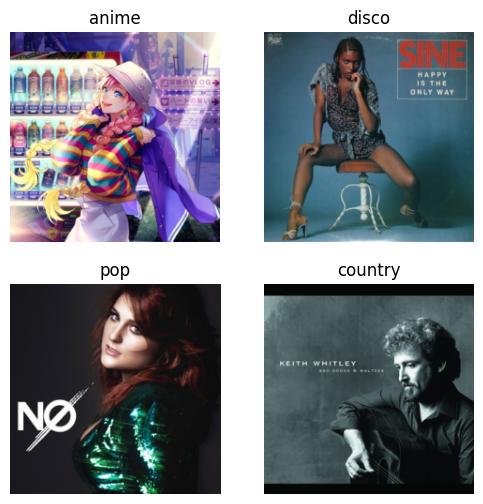

In [47]:
# Показываем партию валидационных данных
dls.valid.show_batch(max_n=4)
# Получаем предсказания и истинные метки
preds, targs = learn.get_preds()
# Вычисляем точность, полноту и F1-счет
precision = precision_score(targs.numpy(), preds.argmax(1), average='weighted')
recall = recall_score(targs.numpy(), preds.argmax(1), average='weighted')
f1 = f1_score(targs.numpy(), preds.argmax(1), average='weighted')

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 score: {f1:.3f}")

# Использование Learner.recorder.values для анализа значений потерь и метрик на каждой эпохе
print("Значения потерь и метрик на каждой эпохе:")
for epoch, values in enumerate(learn.recorder.values):
    print(f"Эпоха {epoch+1}: потери={values[0]:.4f}, точность={values[1]:.4f}, полнота={values[3]:.4f}")


## Выводы по проекту:





В этом проекте я:  
- Исследовала данные:   
тщательно проанализировала структуру и характеристики набора данных, включая возможные дубликаты и аномалии. Для визуализации распределения данных я применила метод t-SNE, что позволило выделить кластеры по разным категориям.  
- Настроила модель:   
загрузив предобученную модель ResNet50, я настроила ее для задачи классификации, выбрав оптимальный learning rate с использованием графика потерь. С помощью колбэка ранней остановки модель завершила обучение, когда метрика valid_loss перестала улучшаться, что позволило избежать переобучения.
- Анализировала производительность: 
итоговые значения точности, полноты и F1-счета показали, что модель достигла приемлемых результатов с точностью около 0.673. Я также изучила результаты по метрикам precision и recall, что помогло выявить области улучшения для дальнейшей оптимизации.  
Проверила сходство:    
- Использовала индексы для поиска похожих изображений в тестовом наборе, визуализировала результаты и поняла, что модель хорошо различает отдельные классы, несмотря на некоторые сходства между смежными категориями.  
Составила отчет:   
- Нормализованная матрица ошибок позволила определить области, где классификатору все еще сложно отличать некоторые классы друг от друга. На основе этого анализа я создала рекомендации по оптимизации для дальнейшего улучшения модели.  
В целом, проект позволил исследовать и применить различные подходы к решению задачи классификации изображений, выявить потенциальные области улучшения и определить перспективные направления для будущих исследований.  
